#Play all


Required import for the assignment

In [ ]:

pip install upsetplot

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for upsetplot: filename=UpSetPlot-0.9.0-py3-none-any.whl size=24814 sha256=00299ed7b4cb15359b781afc8637a76f05eedc2d442cf694c46ed2941ba7a796
  Stored in directory: /root/.cache/pip/wheels/73/42/9f/1c9718ea27f30466d2787e0f7d88a7cb11942e3460c17e0ef6
Successfully built upsetplot


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from scipy.cluster import hierarchy
from scipy.spatial import distance
import os
#from upsetplot import UpSet
from sklearn.preprocessing import LabelEncoder
#from upsetplot import from_memberships

Upload Files

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('You uploaded the file "{name}" {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving new_train.csv to new_train.csv
Saving new_competition.csv to new_competition.csv
You uploaded the file "new_train.csv" 14639533 bytes
You uploaded the file "new_competition.csv" 4879272 bytes


In [ ]:
train_df = pd.read_csv('new_train.csv')
test_df = pd.read_csv('competition.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

TRAINING_DATA = 'gdrive/My Drive/BIP/dataset/train.csv'
COMPETITION_DATA = 'gdrive/My Drive/BIP/dataset/competition.csv'

Mounted at /content/gdrive


In [ ]:
train_df = pd.read_csv(TRAINING_DATA)
test_df = pd.read_csv(COMPETITION_DATA)

In [ ]:
train_df.head()

,Year,Month,Consumer_type,Consumption,Consumer_number,Installation_zone
0,2013,1,domestic,0,MOGV36480546611521,Installation_zone 1
1,2013,1,industrial,5,BECS02817768252637,Installation_zone 2
2,2013,1,domestic,6,VRFW65577141436242,Installation_zone 2
3,2013,1,domestic,1,QLLI18662653137621,Installation_zone 2
4,2013,1,domestic,13,HYUO61823402850645,Installation_zone 2


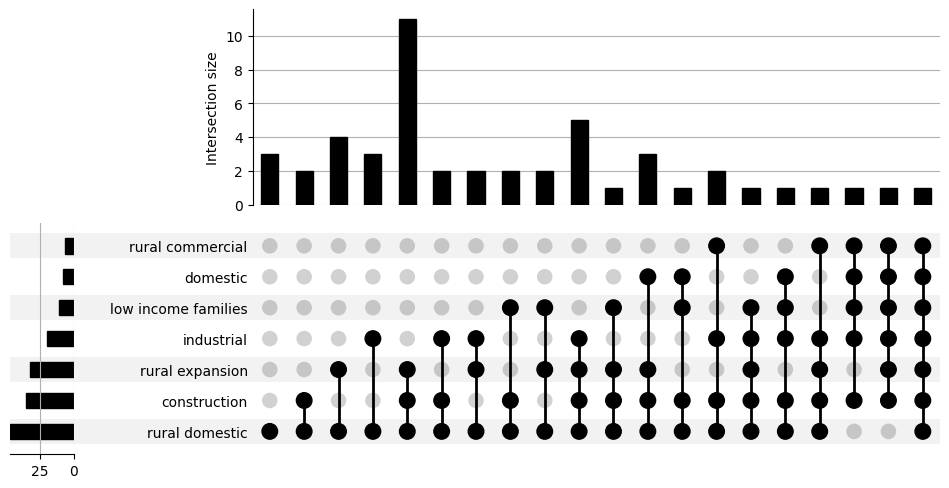

In [ ]:
from upsetplot import plot

all_ct = train_df['Consumer_type'].unique()
output = train_df.groupby(['Installation_zone']).apply(
    lambda group: pd.Series({'CT_set': [True if ct in group['Consumer_type'].unique() else False for ct in all_ct], 'c': 1})
)
output[all_ct] = pd.DataFrame(output.CT_set.tolist(), index= output.index)
output = output.reset_index()
output = output.drop(['Installation_zone','CT_set'], axis = 1)


output = output.groupby(list(all_ct))
output = output['c'].sum()

output.head()
plot(output)


plt.show()

In [ ]:
print(output)

domestic  industrial  rural commercial  construction  low income families  rural domestic  rural expansion
False     False       False             False         False                True            False               3
                                                                                           True                4
                                                      True                 True            True                2
                                        True          False                True            False               2
                                                                                           True               11
                                                      True                 True            False               2
                                                                                           True                1
          True        False             False         False                True            False      

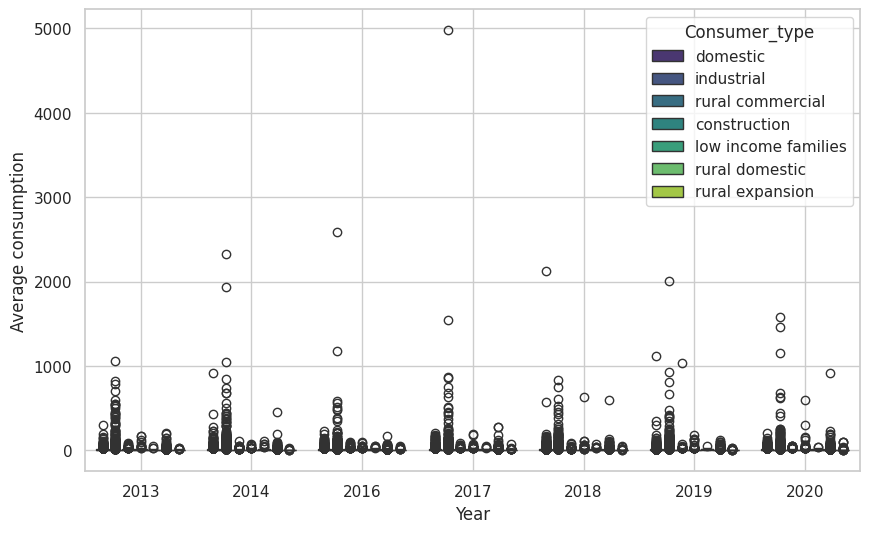

In [ ]:
# BOXPLOT
# BOXPLOT
sns.set(style="whitegrid")

# Group the data set by year and calculate the average consumption for each year
average_consumption_by_year = train_df.groupby('Year')['Consumption'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Year', y='Consumption', hue='Consumer_type', data=train_df, palette='viridis')


plt.xlabel('Year')
plt.ylabel('Average consumption')
plt.grid(True)

plt.show()

In [ ]:
# remove duplicates in the same DataFrame
train_df.drop_duplicates(inplace=True)
# remote lines where consumption is 0
train_df = train_df[train_df['Consumption'] != 0]

In [ ]:
print(train_df.shape)
grouped_data = train_df.groupby('Consumer_type')

# Funktion zur Identifikation und Entfernung von Ausreißern mithilfe des IQR
def remove_outliers(group):
    Q1 = group['Consumption'].quantile(0.25)
    Q3 = group['Consumption'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Zeilen entfernen, wo die consumption als Ausreißer erkannt wird
    cleaned_group = group[(group['Consumption'] >= lower_bound) & (group['Consumption'] <= upper_bound)]

    return cleaned_group

# Ausreißer entfernen und den bereinigten Datensatz speichern
cleaned_df = grouped_data.apply(remove_outliers)

print(cleaned_df.shape)


(268276, 6)
(256117, 6)


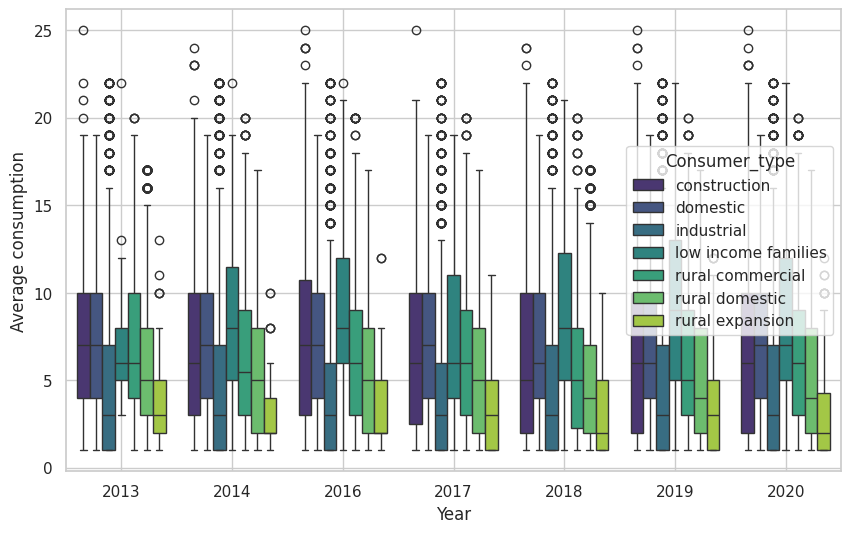

In [ ]:
# BOXPLOT
sns.set(style="whitegrid")

# Group the data set by year and calculate the average consumption for each year
average_consumption_by_year = cleaned_df.groupby('Year')['Consumption'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Year', y='Consumption', hue='Consumer_type', data=cleaned_df, palette='viridis')


plt.xlabel('Year')
plt.ylabel('Average consumption')
plt.grid(True)

plt.show()

In [ ]:
# Klassen, die zusammengefasst werden sollen
classes_to_group = {'rural commercial', 'construction', 'low income families', 'rural expansion'}

# kopie machen für training 2. Modells
cleaned_df['Consumer_type_backup'] = cleaned_df['Consumer_type']

# Ersetze die Klassen in der Spalte "consumer_type"
cleaned_df['Consumer_type'] = cleaned_df['Consumer_type'].replace(classes_to_group, 'grouped_class')

# Zähle die Einträge für jeden Typen nach dem Zusammenfassen
count_by_grouped_class = cleaned_df['Consumer_type'].value_counts()

In [ ]:
def assign_groups(installation_zone):
    if installation_zone in [1, 2]:
        return '1'
    elif installation_zone in [3]:
        return '2'
    elif installation_zone in [4]:
        return '3'
    elif installation_zone in [29, 35]:
        return '4'
    else:
        return '5'

# Wende die Funktion auf die Spalte "Installation_zone" an und erstelle eine neue Spalte "Group"
cleaned_df['Installation_zone'] = cleaned_df['Installation_zone'].str.extract('(\d+)').astype(int)
cleaned_df['Group'] = cleaned_df['Installation_zone'].apply(assign_groups)

# Überprüfe die Zuordnung der Installation-Zonen zu den Gruppen
print(cleaned_df[['Installation_zone', 'Group']].drop_duplicates().sort_values(by='Group'))

                            Installation_zone Group
Consumer_type                                      
construction        1845                    2     1
                    3907                    1     1
                    1595                    3     2
                    3988                    4     3
                    263686                 29     4
                    292365                 35     4
                    256086                 47     5
                    275207                 19     5
                    280218                 28     5
domestic            4044                   46     5
industrial          95766                  31     5
                    95812                  20     5
                    145841                 37     5
low income families 172599                 40     5
construction        252241                 39     5
low income families 204282                 45     5
rural domestic      3480                   15     5
            

In [ ]:
# Aufteilung in Features (X) und Zielvariable (y)
features_for_training = ['Month','Consumption','Group']
X = cleaned_df[features_for_training]
#label_encoder1 = LabelEncoder()
#y = label_encoder1.fit_transform(cleaned_df['Consumer_type'])
y = cleaned_df['Consumer_type']
#label_mapping1 = dict(zip(label_encoder1.classes_, label_encoder1.transform(label_encoder1.classes_)))

# Aufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verwende RandomUnderSampler zur Unterabtastung der Trainingsdaten
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

In [ ]:
#SVM/Entscheidungsbaum
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

models = {
    #"tree1" : DecisionTreeClassifier(max_depth = 8),
    #"rf1" : RandomForestClassifier(n_estimators=100, random_state=42),
    #"rf2" : RandomForestClassifier(n_estimators=70, random_state=42),
    #"rf3" : RandomForestClassifier(n_estimators=40, random_state=42),
    #"gb1" : GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    #"gb2" : GradientBoostingClassifier(n_estimators=80, learning_rate=0.1, random_state=42),
    #"gb3" : GradientBoostingClassifier(n_estimators=60, learning_rate=0.1, random_state=42),
    #"gb4" : GradientBoostingClassifier(n_estimators=40, learning_rate=0.1, random_state=42),
    #"gb5" : GradientBoostingClassifier(n_estimators=100, learning_rate=0.2, random_state=42),
    #"gb6" : GradientBoostingClassifier(n_estimators=80, learning_rate=0.2, random_state=42),
    #"gb7" : GradientBoostingClassifier(n_estimators=60, learning_rate=0.2, random_state=42),
    #"gb8" : GradientBoostingClassifier(n_estimators=40, learning_rate=0.2, random_state=42),
    "knn1" : KNeighborsClassifier(n_neighbors = 9),
    #"knn2" : KNeighborsClassifier(n_neighbors = 13),
    #"knn3" : KNeighborsClassifier(n_neighbors = 17),
    #"knn4" : KNeighborsClassifier(n_neighbors = 5)
}

for k,model in models.items():
  print("Train: " + k)
  model.fit(X_resampled, y_resampled)


Train: knn1


In [ ]:
#Für das oben durchgeführe Training Konfusionsmatrix erstellen
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


for k,model in models.items():
  print("Accuracy of model: " + k)
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print('Accuracy:', accuracy)
  print(classification_report(y_test, y_pred))
  print("\n\n")

Accuracy of model: knn1
Accuracy: 0.7940613774793066
                precision    recall  f1-score   support

      domestic       0.91      0.91      0.91     37930
 grouped_class       0.07      0.32      0.11      1337
    industrial       0.15      0.06      0.09      2879
rural domestic       0.99      0.60      0.74      9078

      accuracy                           0.79     51224
     macro avg       0.53      0.47      0.46     51224
  weighted avg       0.86      0.79      0.82     51224






In [ ]:
selected_df = cleaned_df[cleaned_df['Consumer_type'] == 'grouped_class']

In [ ]:
# Aufteilung in Features (X) und Zielvariable (y)

features_for_training2 = ['Month','Consumption','Group']
X2 = selected_df[features_for_training2]
label_encoder2 = LabelEncoder()
#y2 = label_encoder2.fit_transform(selected_df['Consumer_type_backup'])
#label_mapping2 = dict(zip(label_encoder2.classes_, label_encoder2.transform(label_encoder2.classes_)))
y2 = selected_df['Consumer_type_backup']
# Aufteilung in Trainings- und Testdaten
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Verwende RandomUnderSampler zur Unterabtastung der Trainingsdaten
undersampler = RandomUnderSampler(random_state=42)
X_resampled2, y_resampled2 = undersampler.fit_resample(X_train2, y_train2)

In [ ]:
#SVM/Entscheidungsbaum
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

models2 = {
   # "tree1" : DecisionTreeClassifier(max_depth = 8),
   # "rf1" : RandomForestClassifier(n_estimators=100, random_state=42),
    "rf2" : RandomForestClassifier(n_estimators=70, random_state=42),
  #  "rf3" : RandomForestClassifier(n_estimators=40, random_state=42),

 #  "gb1" : GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
 #   "gb2" : GradientBoostingClassifier(n_estimators=80, learning_rate=0.1, random_state=42),
 #   "gb3" : GradientBoostingClassifier(n_estimators=60, learning_rate=0.1, random_state=42),
 #   "gb4" : GradientBoostingClassifier(n_estimators=40, learning_rate=0.1, random_state=42),
 #    "gb5" : GradientBoostingClassifier(n_estimators=100, learning_rate=0.2, random_state=42),
 #   "gb6" : GradientBoostingClassifier(n_estimators=80, learning_rate=0.2, random_state=42),
 #   "gb7" : GradientBoostingClassifier(n_estimators=60, learning_rate=0.2, random_state=42),
 #   "gb8" : GradientBoostingClassifier(n_estimators=40, learning_rate=0.2, random_state=42),
 #  "knn1" : KNeighborsClassifier(n_neighbors = 9),
 #   "knn2" : KNeighborsClassifier(n_neighbors = 13),
 #   "knn3" : KNeighborsClassifier(n_neighbors = 17),
 #  "knn4" : KNeighborsClassifier(n_neighbors = 5),
 #   "svm1" :  LinearSVC(random_state=42),
 #   "svm2" : SVC(kernel='rbf', random_state=42),
#   "svm3" : SVC(kernel='sigmoid', random_state=42),
#    "svm4" : SVC(kernel='poly', random_state=42),
}

for k,model in models2.items():
  print("Train: " + k)
  model.fit(X_resampled2, y_resampled2)


Train: rf2


In [ ]:
for k,model in models2.items():
  print("Accuracy of model: " + k)
  y_pred2 = model.predict(X_test2)
  accuracy = accuracy_score(y_test2, y_pred2)
  print('Accuracy:', accuracy)
  print(classification_report(y_test2, y_pred2))
  print("\n\n")

Accuracy of model: rf2
Accuracy: 0.5176824680210684
                     precision    recall  f1-score   support

       construction       0.34      0.33      0.33       278
low income families       0.24      0.54      0.33       183
   rural commercial       0.83      0.53      0.65       781
    rural expansion       0.59      0.94      0.72        87

           accuracy                           0.52      1329
          macro avg       0.50      0.59      0.51      1329
       weighted avg       0.63      0.52      0.54      1329






In [ ]:
test_df.head()

,Month,Consumption,Consumer_number,Group
0,1,1,VENX08444954462680,1
1,1,2,GRXC33020746550125,1
2,1,1,FCGQ19814303536339,1
3,1,5,EQKL85694875580467,2
4,1,14,KCXW91343862250032,2


In [ ]:
# data engineering with competition dataset too
test_df['Installation_zone'] = test_df['Installation_zone'].str.extract('(\d+)').astype(int)

def assign_groups2(installation_zone):
    if installation_zone in [1, 2]:
        return '1'
    elif installation_zone in [3]:
        return '2'
    elif installation_zone in [4]:
        return '3'
    elif installation_zone in [29, 35]:
        return '4'
    else:
        return '5'
# Wende die Funktion auf die Spalte "Installation_zone" an und erstelle eine neue Spalte "Group"
test_df['Group'] = test_df['Installation_zone'].apply(assign_groups2)


KeyError: 'Installation_zone'

In [ ]:
test_df.sample(10)

,Month,Consumption,Consumer_number,Group
2858,9,10,FFAR48543703647689,2
3249,1,5,GUBM52912770402798,2
14063,10,4,YFQS65579402206574,1
8079,3,0,SXZF91555008327649,5
1342,4,14,IDLV25802308930770,3
6522,10,2,QKIA01274967632022,3
12482,10,0,JPEL95207741089870,5
3346,2,0,DWZT19944471696987,1
8833,8,7,PJMC90799657549559,5
10589,2,5,MSEP68991962276810,5


In [ ]:
# Maybe dropping some columns, depending on the test-dataset
test_df = test_df.drop('Installation_zone', axis=1)
test_df = test_df.drop('Year', axis=1)

#test_df = test_df.drop('Consumer_type', axis=1)

In [ ]:
test_df.sample(10)

,Month,Consumption,Consumer_number,Group
5259,1,0,QBXW55321576294984,6
79024,2,6,BNFM13008087311402,5
67312,8,11,NGTM95041965579545,5
47947,4,7,NZJW47968455074082,1
21559,1,11,UJEF81983365449266,4
80094,5,4,UHZZ18341231517022,6
40455,4,2,JXCZ24756838485283,4
79112,5,4,JFUG40852550317548,4
44443,7,2,JUDW35689119891044,2
47212,10,0,VSKN21078342534401,6


In [ ]:
# Klassifiziere die Daten mit dem ersten Decision Tree (tree1)

for k,model in models.items():
  model1 = model

for k,model in models2.items():
  model2 = model

result_df = pd.DataFrame(columns=['Consumer_number', 'Final_Prediction'])


for index, row in test_df.iterrows():
    # row ist eine Pandas Series, die die Werte der aktuellen Zeile enthält
    # Du kannst auf die Werte durch den Spaltennamen zugreifen, z.B. row['Spaltenname']
    consumer_number = row['Consumer_number']
    rowToPredict = pd.DataFrame([row.drop('Consumer_number')], columns=test_df.columns.drop('Consumer_number'))
    print(rowToPredict)
    # Verwende die predict-Methode auf dem DataFrame
    # AND Group Installation Zone 1-4
    if row['Consumption'] == 0 and (row['Group'] == 5 or row['Group'] == 4):
        final_prediction = '[rural domestic]'
        print("default prediction: " ,prediction)
    elif row['Consumption'] == 0:
        final_prediction = '[domestic]'
        print("default prediction: " ,prediction)
    else:
        prediction = model1.predict(rowToPredict)
        print("first prediction: " ,prediction)
    if prediction == 'grouped_class':
        final_prediction = model2.predict(rowToPredict)
        print("final_prediction: ", final_prediction)
    else:
      final_prediction = prediction
    df2 = pd.DataFrame({'Consumer_number': [consumer_number], 'Final_Prediction': final_prediction})
    result_df = pd.concat([result_df, df2], ignore_index=True)




Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
       Month  Consumption Group
16745     12           10     3
first prediction:  ['domestic']
       Month  Consumption Group
16746     12           18     1
first prediction:  ['domestic']
       Month  Consumption Group
16747     12            4     5
first prediction:  ['grouped_class']
final_prediction:  ['rural expansion']
       Month  Consumption Group
16748     12           15     5
first prediction:  ['rural domestic']
       Month  Consumption Group
16749     12            0     3
default prediction:  ['rural domestic']
       Month  Consumption Group
16750     12            0     5
default prediction:  ['rural domestic']
       Month  Consumption Group
16751     12            0     5
default prediction:  ['rural domestic']
       Month  Consumption Group
16752     12            0     1
default prediction:  ['rural domestic']
       Month  Consumption Group
16753     12            0     3
default prediction:

In [ ]:
grouped_df = result_df.groupby('Final_Prediction').size().reset_index(name='Anzahl')

# Jetzt enthält grouped_df die Anzahl jeder Ausprägung von 'Final_Prediction'
print(grouped_df)

      Final_Prediction  Anzahl
0         construction     961
1             domestic   11322
2           industrial     546
3  low income families     449
4     rural commercial     762
5       rural domestic    2374
6      rural expansion    1865


In [ ]:

result_df.to_csv('resultMultipleModelsAttemptWithZeroIsDomestic2ndTry.csv', index=False)

# Herunterladen der CSV-Datei
from google.colab import files

files.download('resultMultipleModelsAttemptWithZeroIsDomestic2ndTry.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

in Competition alle 0 Consumption auf domestic

Split Data, dann syntetisch herstellen

UpSetPlot